Lettura dati da dataset annuali

In [1]:
# import pandas
import pandas as pd

# read all datasets
files = [
    '../data/EstrazioneTamponi_orig/EstrazioniTamponi_2020.csv',
    '../data/EstrazioneTamponi_orig/EstrazioniTamponi_2021.csv', # nok eventualmente correggibili
    '../data/EstrazioneTamponi_orig/EstrazioniTamponi_2022.csv', # nessun nok
    '../data/EstrazioneTamponi_orig/EstrazioniTamponi_2023.csv'
]

data = pd.concat([pd.read_csv(f, skipinitialspace=True) for f in files])
orig_len = len(data)
print("records: ", orig_len)


C:\Users\Arbiter\AppData\Local\Temp\ipykernel_12660\1318339252.py:12: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f, skipinitialspace=True) for f in files])
C:\Users\Arbiter\AppData\Local\Temp\ipykernel_12660\1318339252.py:12: DtypeWarning: Columns (5,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f, skipinitialspace=True) for f in files])


records:  690180


C:\Users\Arbiter\AppData\Local\Temp\ipykernel_12660\1318339252.py:12: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f, skipinitialspace=True) for f in files])


In [2]:
# print statistics for each dataset
column_ok = ['Data Accettazione', 'Ora Accettazione', 'Sesso', 'Codice Reparto',
       'Nome Reparto', 'Codice Analisi', 'Nome Analisi', 'Materiale',
       'Conteggio']

extra_columns = [c for c in data.columns if c not in column_ok]
print(extra_columns)

# get line where extra columns are not null
nok_indices = data[extra_columns].notnull().any(axis=1)

# get line where date is not in the right format
nok_date_indices = ~data['Data Accettazione'].str.contains('\d{4} / \d{2} / \d{2}', na=False)

nok_indices = nok_indices | nok_date_indices

print(len(data[nok_indices]), "nok rows")


['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11']
27 nok rows


In [3]:
# save nok to file
data[nok_indices].to_csv('../data/EstrazioneTamponi/EstrazioniTamponi_nok_full.csv', index=False)

# save clean data (ok) to file
clean_data = data[~nok_indices]

# drop extra columns
clean_data = pd.DataFrame(clean_data, columns=column_ok)

for c in column_ok:
    # remove leading and trailing spaces
    clean_data[c].str.strip()
    
    # convert to int if possible
    if c in ['Conteggio', 'Codice Analisi']:
        clean_data[c] = clean_data[c].astype(int)
    
    # convert to datetime
    if c in ['Data Accettazione', 'Ora Accettazione']:
        clean_data['DataOraAccettazione'] = pd.to_datetime(clean_data['Data Accettazione'] + ' ' + clean_data['Ora Accettazione'], format='%Y / %m / %d %H:%M:%S', errors='raise')

# drop Data Accettazione and Ora Accettazione
clean_data = clean_data.drop(columns=['Data Accettazione', 'Ora Accettazione'])
# move DataOraAccettazione to the first column
clean_data = clean_data[['DataOraAccettazione'] + [c for c in clean_data.columns if c != 'DataOraAccettazione']]
# save to file
clean_data.to_csv('../data/EstrazioneTamponi/EstrazioniTamponi_clean_full.csv', index=False)

print("ok records: ", len(clean_data), (len(clean_data) / orig_len) * 100, "%" )


ok records:  690153 99.99608797704947 %


In [2]:
# load from file
clean_data = pd.read_csv('../data/EstrazioneTamponi/EstrazioniTamponi_clean_full.csv')
clean_data['DataOraAccettazione'] = pd.to_datetime(clean_data['DataOraAccettazione'], format='%Y-%m-%d %H:%M:%S', errors='raise')

# print statistics
print(clean_data.describe())

       Codice Analisi      Conteggio
count   690153.000000  690153.000000
mean     16054.734315       1.001246
std          2.381719       0.042506
min      16053.000000       1.000000
25%      16053.000000       1.000000
50%      16053.000000       1.000000
75%      16058.000000       1.000000
max      16059.000000      13.000000


In [5]:
# print unique values for each column and number of occurrences in order of occurrences (descending)
for c in clean_data.columns:
    print(c, "unique values: ")
    print(clean_data[c].value_counts())
    print("\n\n")

DataOraAccettazione unique values: 
2020-10-17 12:14:00    567
2022-01-14 08:39:00    383
2021-03-17 07:03:00    369
2021-03-26 07:54:00    353
2021-04-09 07:09:00    352
                      ... 
2021-07-28 13:05:00      1
2021-07-28 03:42:00      1
2021-07-28 08:59:00      1
2021-07-28 11:19:00      1
2023-12-31 11:45:00      1
Name: DataOraAccettazione, Length: 248795, dtype: int64



Sesso unique values: 
F    386840
M    303123
N       190
Name: Sesso, dtype: int64



Codice Reparto unique values: 
46720     90275
20193     76565
10001     40090
10044     35963
20176     30166
          ...  
10572         1
O00800        1
11574         1
O00100        1
10271         1
Name: Codice Reparto, Length: 581, dtype: int64



Nome Reparto unique values: 
CHIERI - Osp. Maggiore                        90275
RM DEA                                        76565
MOL PS Medicina                               40090
MOL 01-OBI EMERGENZA                          35963
SA Pronto Soccorso        

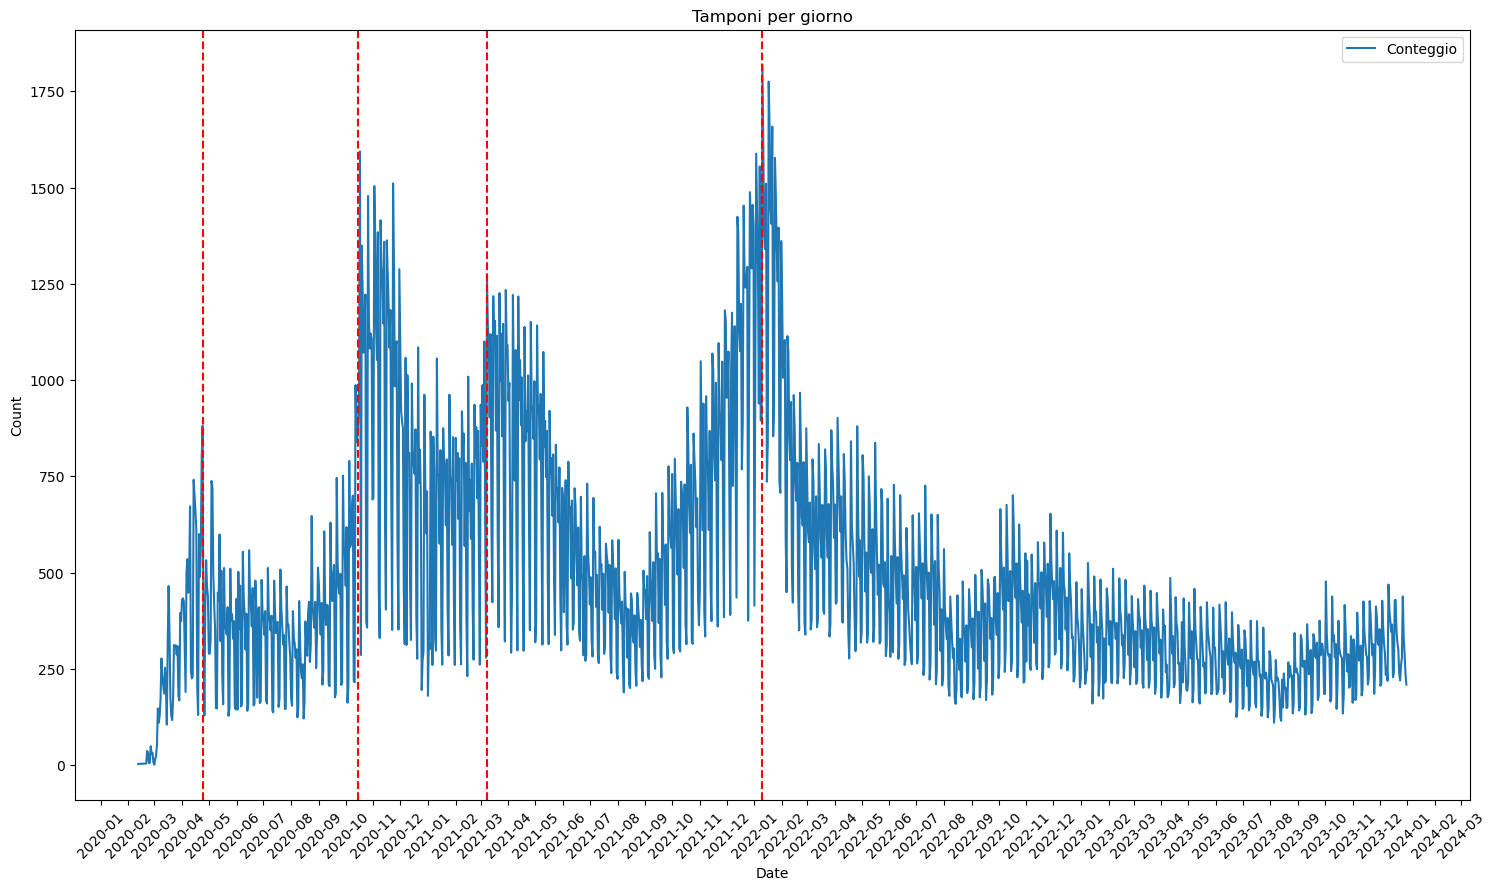

In [6]:
# plot tamponi per giorno
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

picchi_pandemici = [
    '2020-04-25',
    '2020-10-15',
    '2021-03-08',
    '2022-01-10',
]

# plot vertical lines for each picco pandemico
plot_data = clean_data.drop(columns=['Codice Reparto', 'Codice Analisi'])
plot_data.groupby(plot_data['DataOraAccettazione'].dt.date).sum().plot()
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
for p in picchi_pandemici:
    plt.axvline(x=p, color='r', linestyle='--')
plt.show()


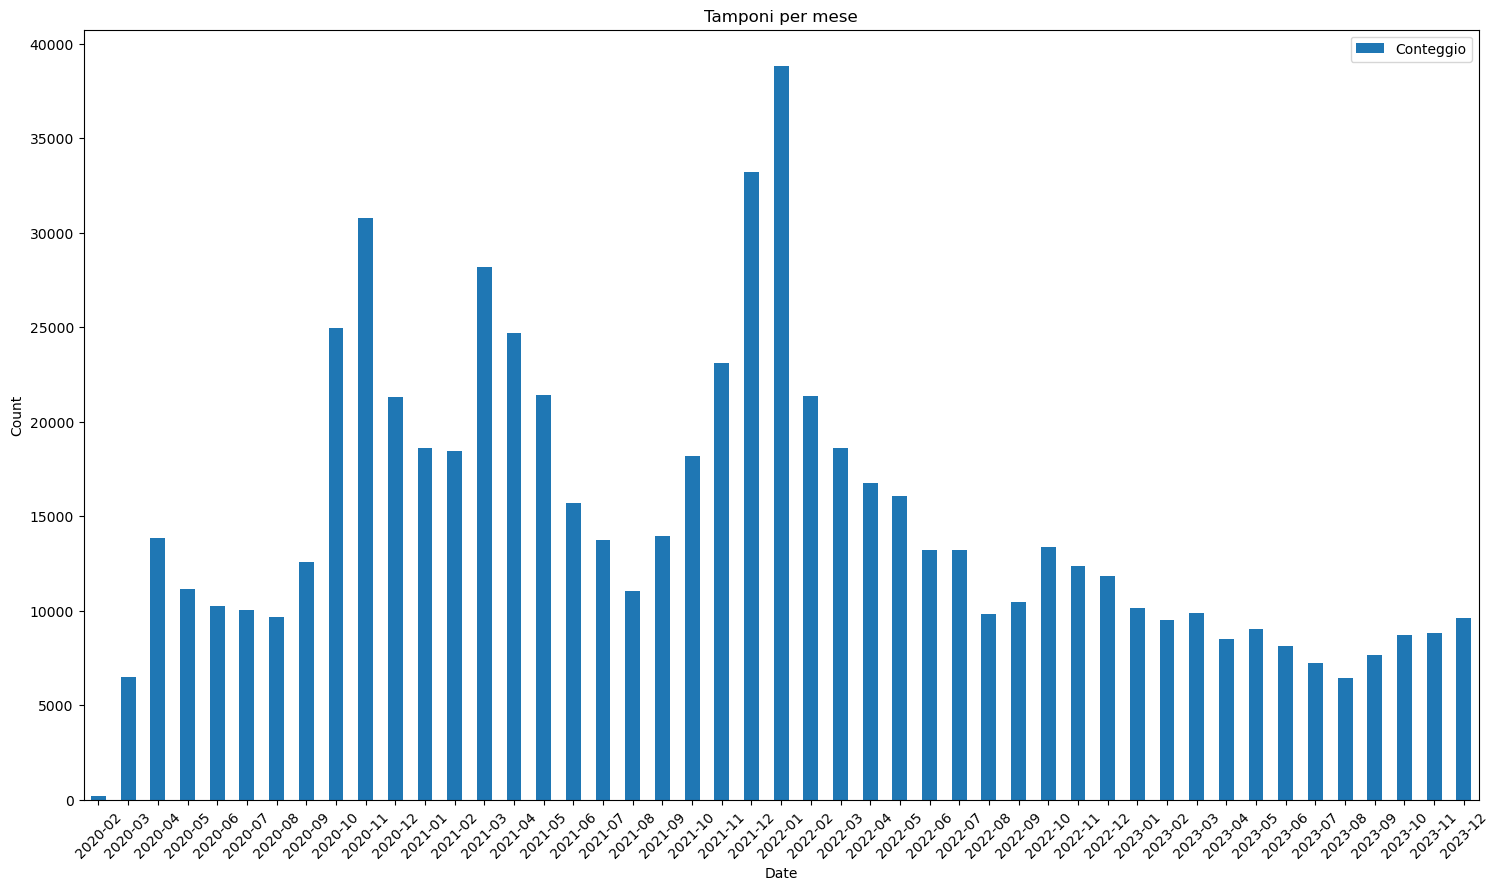

In [7]:
# plot tamponi per giorno
# aggrega x per mese (histogram)

plot_data.groupby(plot_data['DataOraAccettazione'].dt.to_period("M")).sum().plot(kind='bar')
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per mese")
plt.xticks(rotation=45)
plt.gcf().set_size_inches(18, 10)
plt.show()


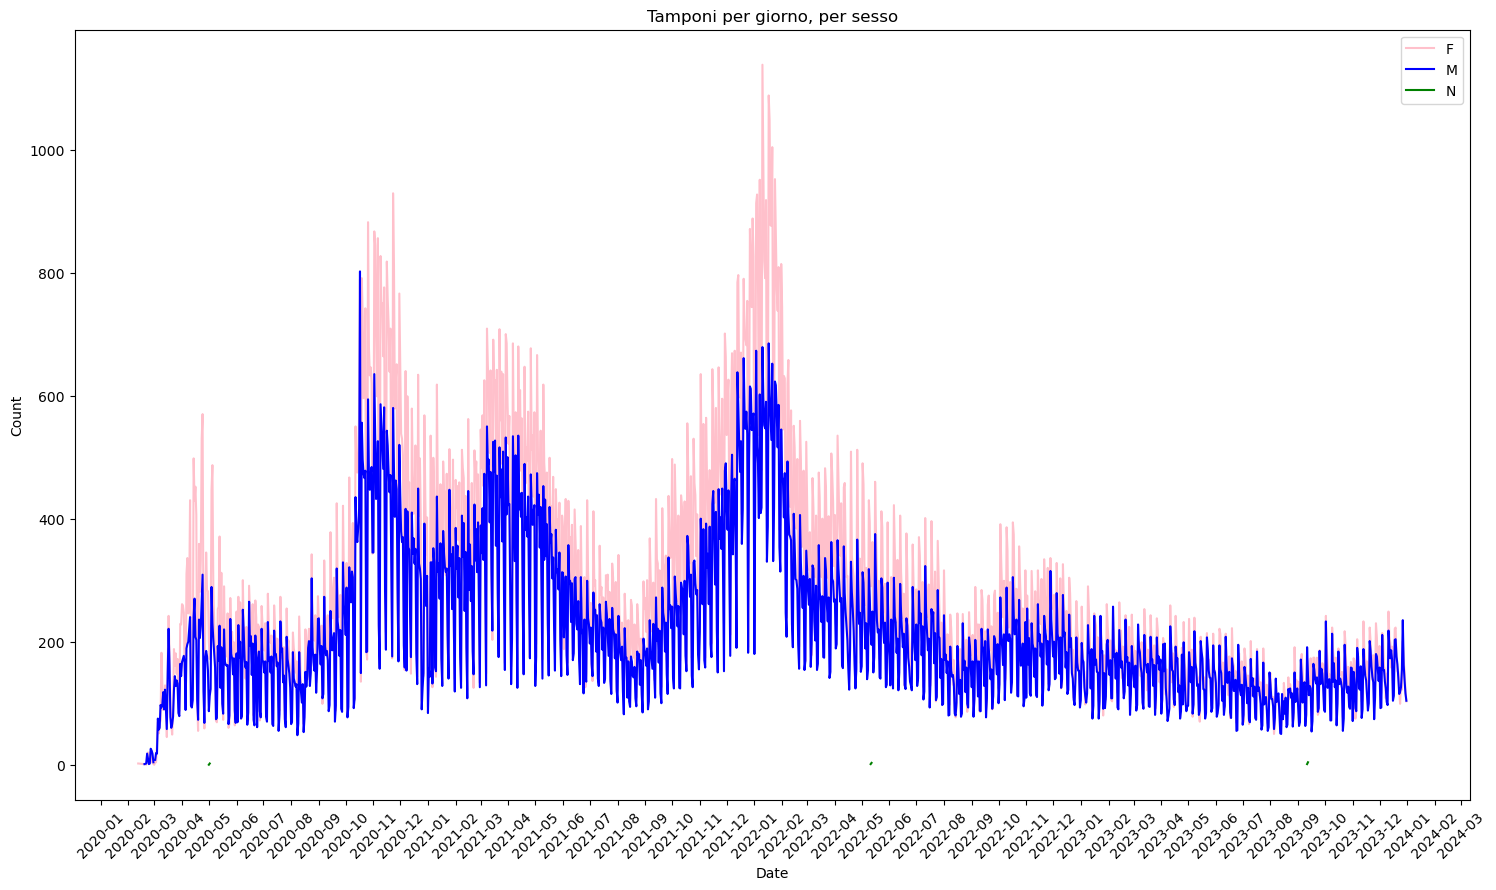

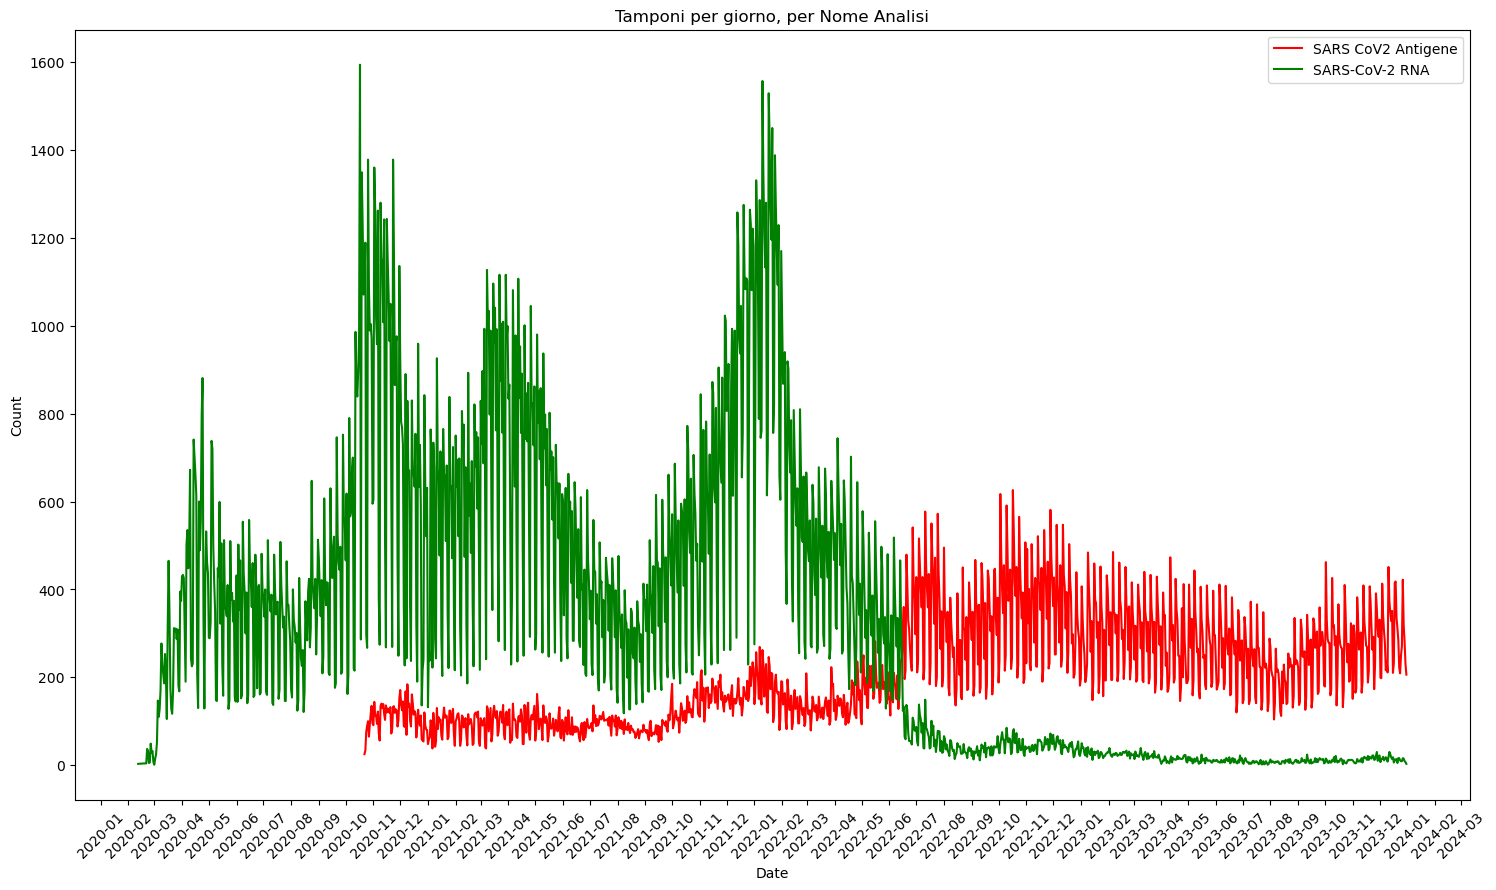

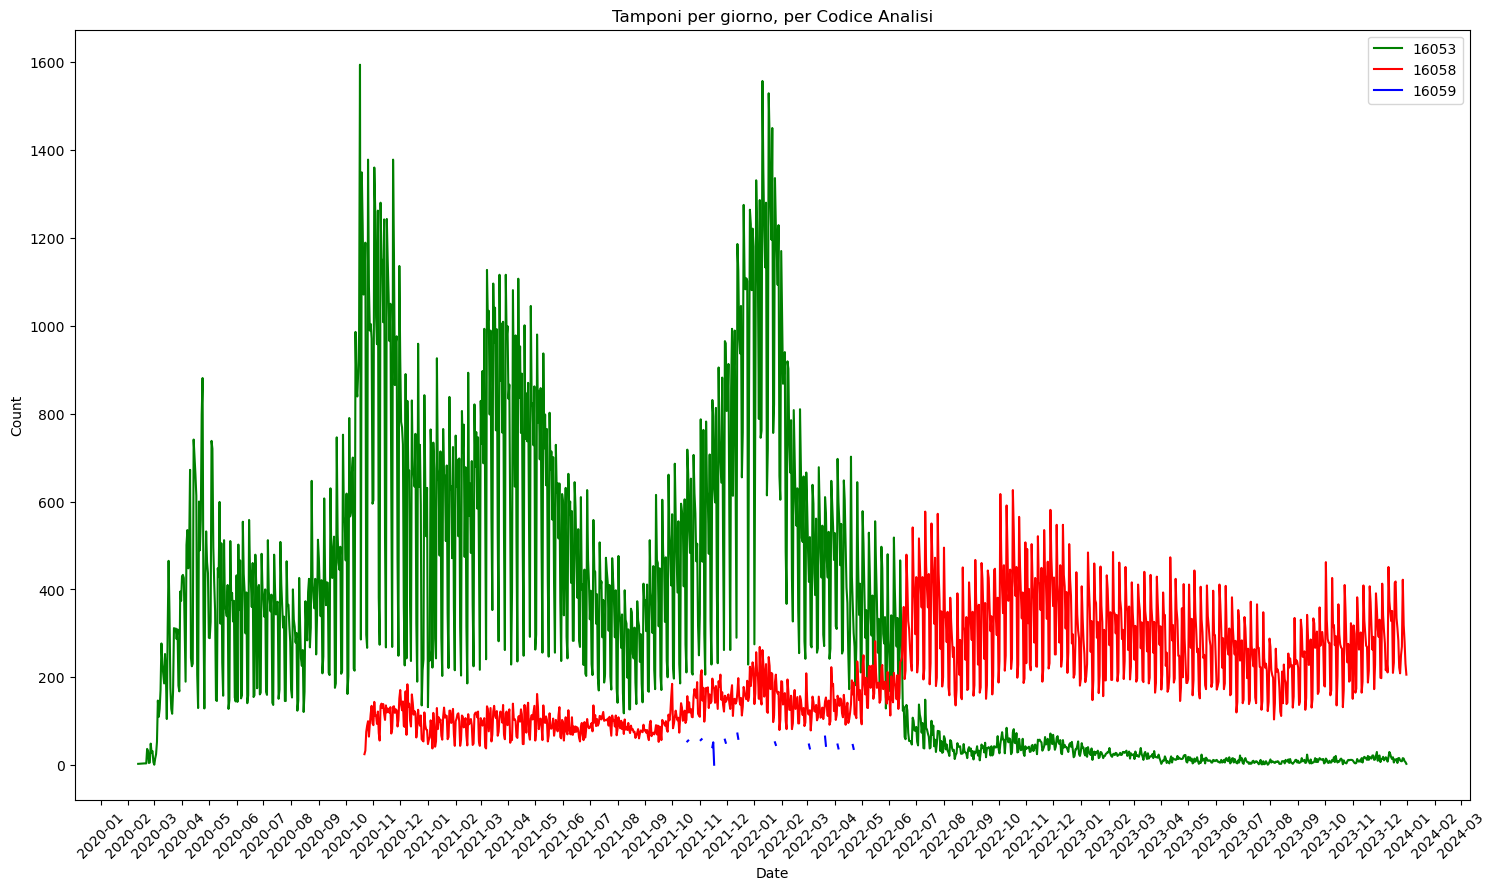

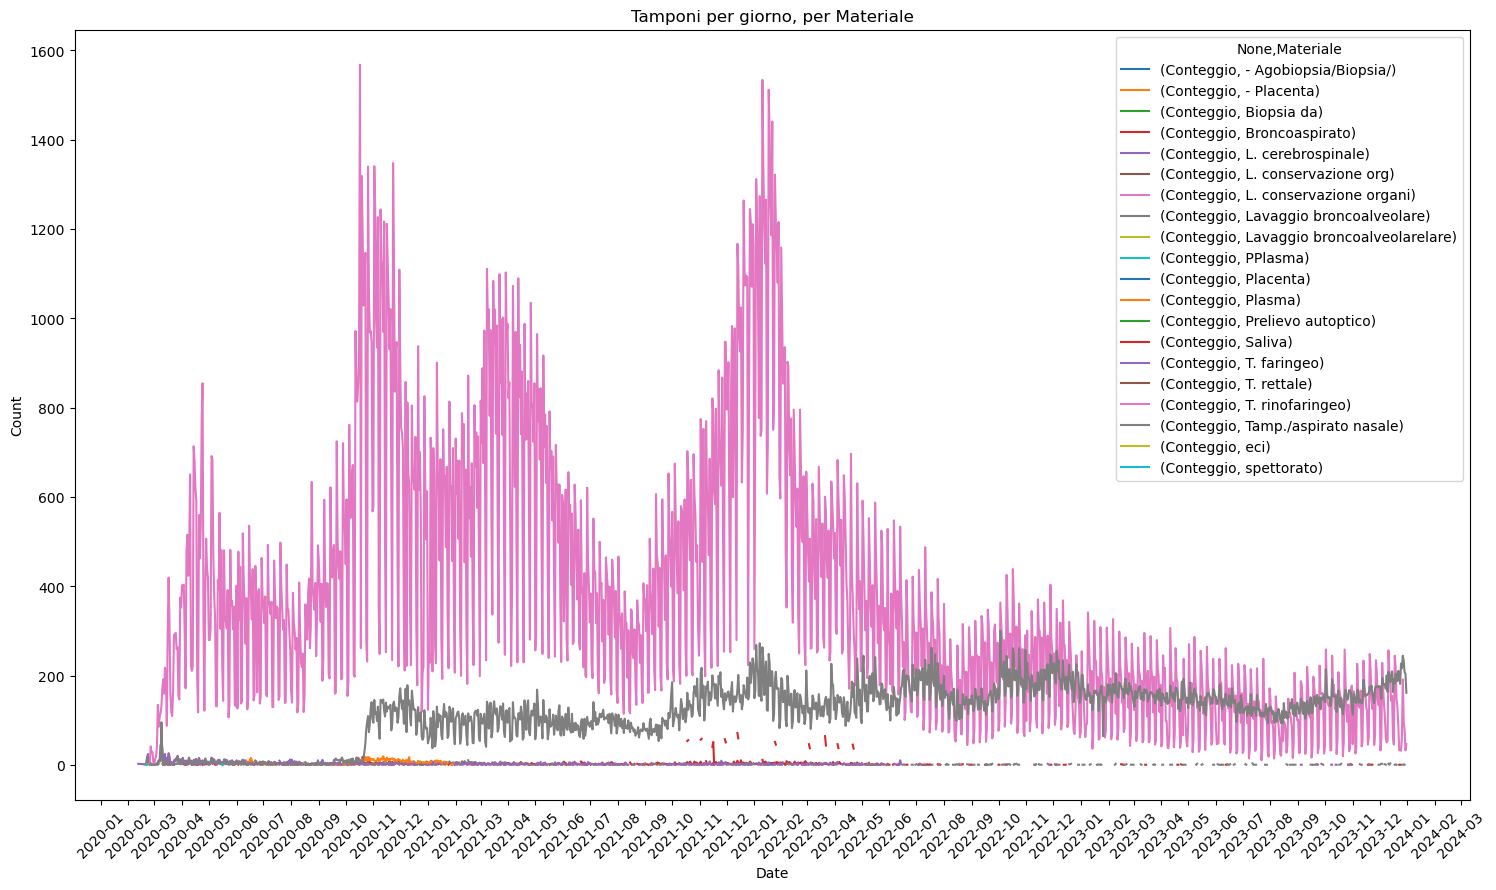

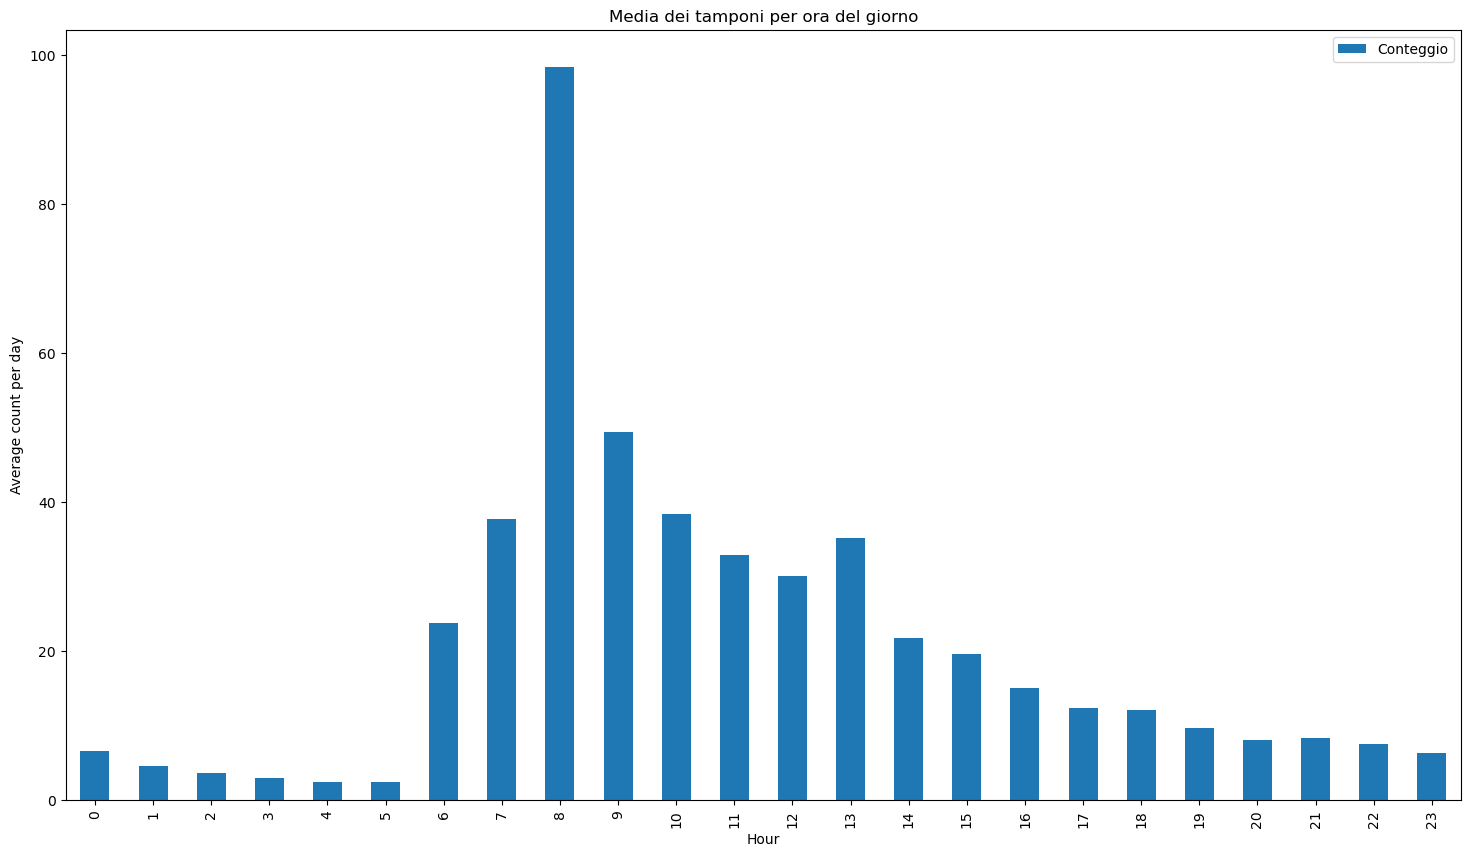

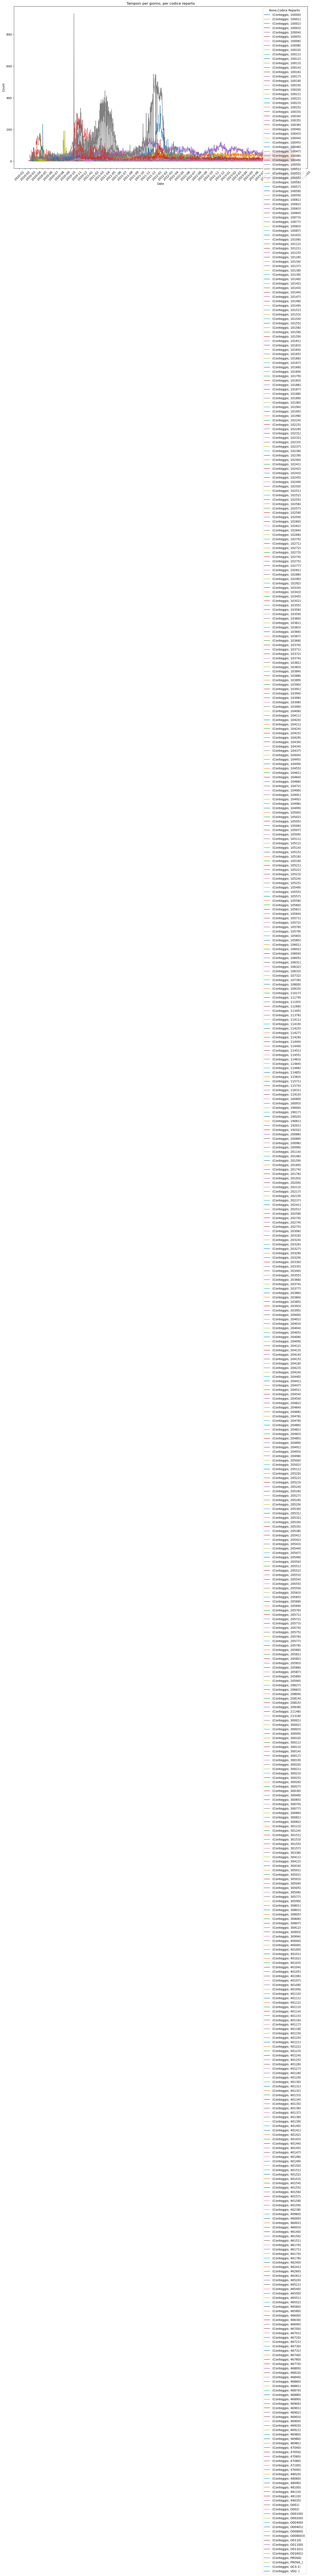

In [8]:
# plot tamponi per giorno, per sesso (M = blue, F = pink, N = green)

colors = ['pink', 'blue', 'green']
plot_data = clean_data.drop(columns=['Codice Reparto', 'Codice Analisi'])
plot_data = plot_data.groupby([plot_data['DataOraAccettazione'].dt.date, 'Sesso']).sum().unstack().plot(color=colors)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno, per sesso")
plt.legend(['F', 'M', 'N'])
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
plt.show()

# plot tamponi per giorno, per Nome Analisi
colors = ['red', 'green', 'blue']
plot_data = clean_data.drop(columns=['Codice Reparto', 'Codice Analisi'])
plot_data = plot_data.groupby([plot_data['DataOraAccettazione'].dt.date, 'Nome Analisi']).sum().unstack().plot(color=colors)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno, per Nome Analisi")
plt.legend(["SARS CoV2 Antigene", "SARS-CoV-2 RNA"])
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
plt.show()

# plot tamponi per giorno, per Codice Analisi
colors = ['green', 'red', 'blue']
plot_data = clean_data.drop(columns=['Codice Reparto'])
plot_data = plot_data.groupby([plot_data['DataOraAccettazione'].dt.date, 'Codice Analisi']).sum().unstack().plot(color=colors)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno, per Codice Analisi")
plt.legend(["16053", "16058", "16059"])
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
plt.show()

# plot tamponi per giorno, per Materiale
plot_data = clean_data.drop(columns=['Codice Reparto', 'Codice Analisi'])
plot_data = plot_data.groupby([plot_data['DataOraAccettazione'].dt.date, 'Materiale']).sum().unstack().plot()
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno, per Materiale")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
plt.show()

# plot tamponi per ora del giorno
# histogram
# dividi il conteggio per numero di giorni
number_of_days = len(clean_data['DataOraAccettazione'].dt.date.unique())
plot_data = clean_data.drop(columns=['Codice Reparto', 'Codice Analisi'])
plot_data = plot_data.groupby(plot_data['DataOraAccettazione'].dt.hour).sum()
plot_data = plot_data / number_of_days
plot_data.plot(kind='bar')
plt.xlabel("Hour")
plt.xticks(range(0, 24))
plt.ylabel("Average count per day")
plt.title("Media dei tamponi per ora del giorno")
plt.gcf().set_size_inches(18, 10)
plt.show()

# plot tamponi per giorno, per codice reparto
plot_data = clean_data.drop(columns=['Codice Analisi'])
plot_data = plot_data.groupby([plot_data['DataOraAccettazione'].dt.date, 'Codice Reparto']).sum().unstack().plot()
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno, per codice reparto")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
plt.show()


In [9]:
# quanti codici reparto ci sono?
print("Codici reparto: ", clean_data['Codice Reparto'].nunique())

# print of tamponi per codice reparto
print("Tamponi per codice reparto: ")
count = clean_data['Codice Reparto'].value_counts()
for i, c in enumerate(count.index):
    print(c, count.iloc[i])

Codici reparto:  581
Tamponi per codice reparto: 
46720 90275
20193 76565
10001 40090
10044 35963
20176 30166
10505 23776
10499 21457
20099 16282
30030 14666
20270 11938
10003 8217
30026 7730
10014 6889
10372 6796
20571 6694
10245 6364
30025 6182
20568 6011
19000 5744
10233 5195
10198 4852
20355 4766
30505 4728
10390 4613
10057 4471
30994 4356
20395 4311
10140 4291
20524 4164
10045 4062
20335 3719
20340 3651
46860 3635
20523 3421
20520 3419
10142 3408
10035 3396
20527 3341
10002 3105
10046 2989
20400 2907
30506 2884
10632 2810
10240 2695
20663 2664
10391 2559
10249 2542
10257 2541
10232 2511
10361 2474
10363 2434
10241 2419
10398 2414
11631 2301
10389 2248
20522 2235
20368 2177
10583 2174
20526 2141
20374 2135
20502 2084
10242 2082
10231 2022
20528 2018
48090 1981
10186 1882
10224 1834
20555 1807
30599 1791
10384 1771
20532 1721
30912 1715
30416 1712
10023 1698
10366 1684
10506 1597
20587 1596
30010 1589
30338 1583
10004 1536
10016 1485
10255 1474
10103 1466
10381 1465
10502 1461
46700

In [10]:
# quante righe con codice analisi = 16059 ?
print("Righe con codice analisi = 16059: ", len(clean_data[clean_data['Codice Analisi'] == 16059]))

Righe con codice analisi = 16059:  1018


In [11]:
# raggruppa tamponi per giorno -> somma
# quale giorno ha avuto più tamponi? Quanti?

print("Giorno con più tamponi: ", clean_data.groupby(clean_data['DataOraAccettazione'].dt.date).sum().idxmax())
print("Numero di tamponi: ", clean_data.groupby(clean_data['DataOraAccettazione'].dt.date).sum().max())

# giorno medio? quanti?
print("Giorno medio: ", clean_data.groupby(clean_data['DataOraAccettazione'].dt.date).sum().mean())
print("Numero di tamponi: ", clean_data.groupby(clean_data['DataOraAccettazione'].dt.date).sum().mean())

# # giorno minimo? quanti?
# print("Giorno minimo: ", clean_data.groupby(clean_data['DataOraAccettazione'].dt.date).sum().idxmin())
# print("Numero di tamponi: ", clean_data.groupby(clean_data['DataOraAccettazione'].dt.date).sum().min())

Giorno con più tamponi:  Codice Analisi    2022-01-10
Conteggio         2022-01-10
dtype: object
Numero di tamponi:  Codice Analisi    29201717
Conteggio             1819
dtype: int64
Giorno medio:  Codice Analisi    7.847183e+06
Conteggio         4.893860e+02
dtype: float64
Numero di tamponi:  Codice Analisi    7.847183e+06
Conteggio         4.893860e+02
dtype: float64


In [12]:
# quale materiale è stato usato di più?
print("Materiale usato di più: ", clean_data['Materiale'].value_counts().idxmax())
print("Numero di tamponi: ", clean_data['Materiale'].value_counts().max())

# quanti materiali diversi ci sono?
print("Materiali diversi: ", clean_data['Materiale'].nunique())

Materiale usato di più:  T. rinofaringeo
Numero di tamponi:  516114
Materiali diversi:  20


In [13]:
# quale codice reparto ha avuto più tamponi?
print("Codice reparto con più tamponi: ", clean_data['Codice Reparto'].value_counts().idxmax())
print("Numero di tamponi: ", clean_data['Codice Reparto'].value_counts().max())

Codice reparto con più tamponi:  46720
Numero di tamponi:  90275


Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')


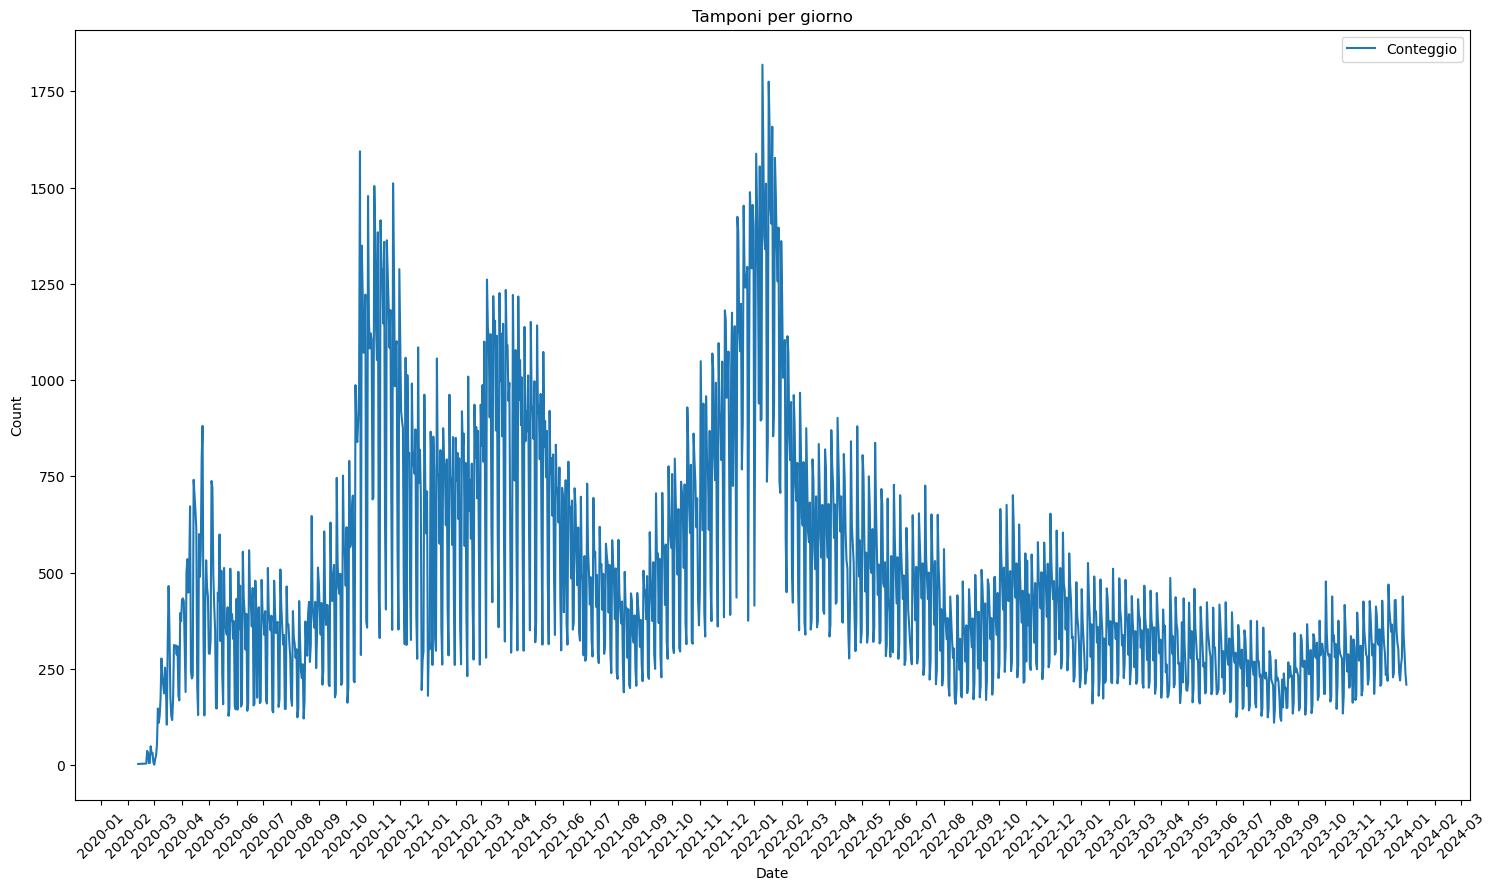

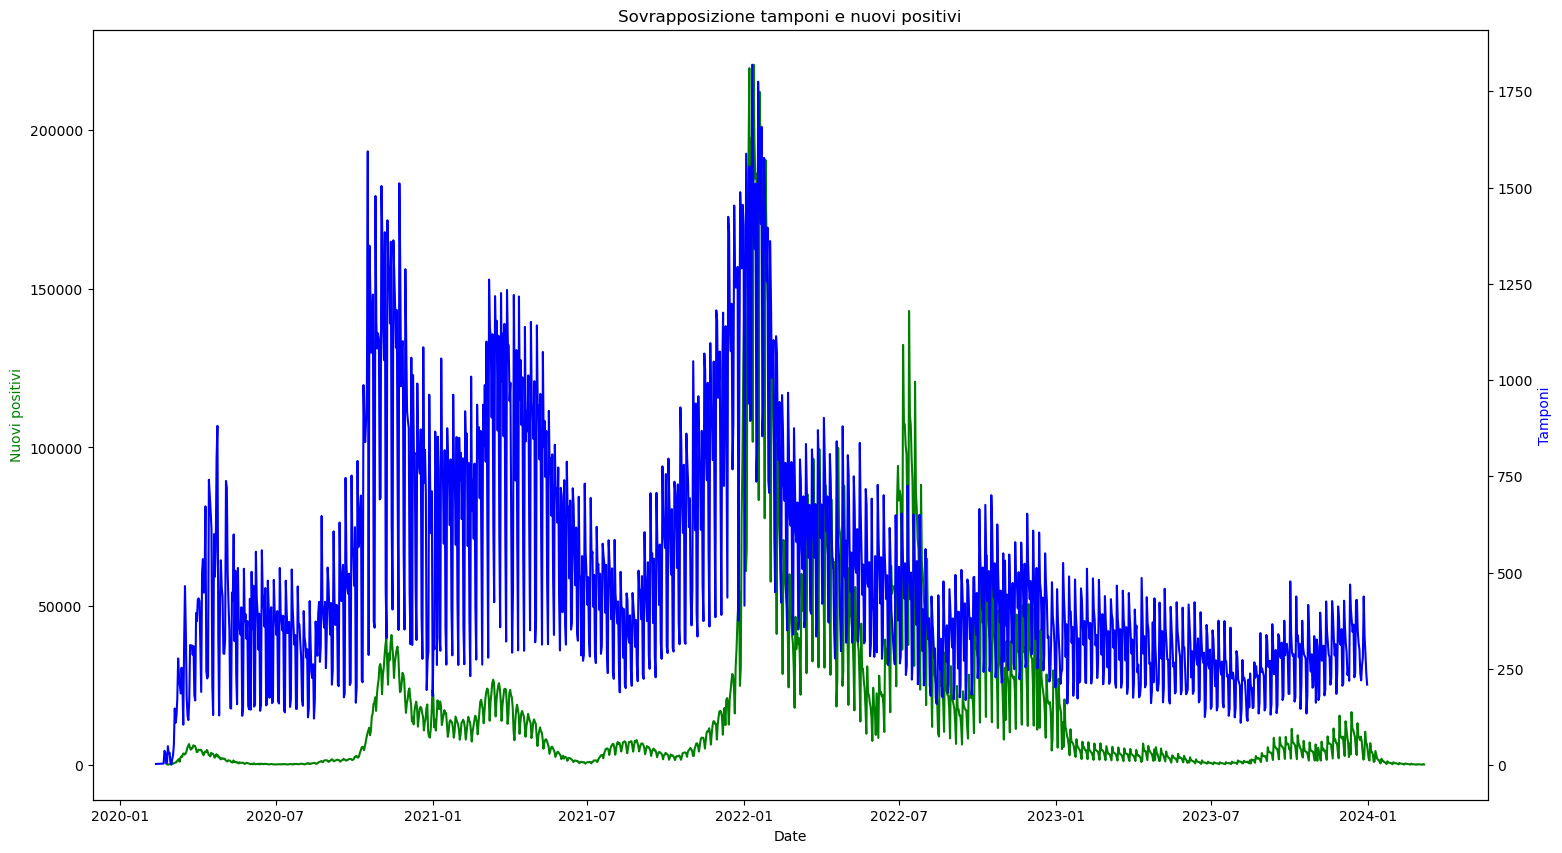

In [14]:
# EXTRA: Sovrapposizione con contagi COVID-19
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests

# Load COVID-19 data from the provided GitHub repository
# Presidenza del Consiglio dei Ministri - Dipartimento della Protezione Civile
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
response = requests.get(url)
data = pd.read_csv(url, parse_dates=['data'])

# print columns
print(data.columns)

# Drop unnecessary columns
plot_data_pcm_dpc = data[['data', 'nuovi_positivi']]

# plot tamponi per giorno
plot_data = clean_data.drop(columns=['Codice Reparto', 'Codice Analisi'])
plot_data.groupby(plot_data['DataOraAccettazione'].dt.date).sum().plot()
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Tamponi per giorno")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().set_size_inches(18, 10)
plt.show()

# sovrapposizione con nuovi_positivi
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(plot_data_pcm_dpc['data'], plot_data_pcm_dpc['nuovi_positivi'], 'g-')
ax2.plot(plot_data.groupby(plot_data['DataOraAccettazione'].dt.date).sum(), 'b-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nuovi positivi', color='g')
ax2.set_ylabel('Tamponi', color='b')
plt.title("Sovrapposizione tamponi e nuovi positivi")
plt.gcf().set_size_inches(18, 10)
plt.show()

